In [1]:
import pandas as pd
import datetime as dt
import numpy as np

from csv import writer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('btc_open.csv')
print(df)

      Unnamed: 0 formatted_date          high           low          open  \
0              0     2019-01-01   3850.913818   3707.231201   3849.216309   
1              1     2019-01-02   3947.981201   3817.409424   3931.048584   
2              2     2019-01-03   3935.685059   3826.222900   3832.040039   
3              3     2019-01-04   3865.934570   3783.853760   3851.973877   
4              4     2019-01-05   3904.903076   3836.900146   3836.519043   
...          ...            ...           ...           ...           ...   
1515        1515     2023-02-24  24103.705078  23007.072266  23200.125000   
1516        1516     2023-02-25  23210.210938  22861.558594  23174.150391   
1517        1517     2023-02-26  23654.367188  23084.220703  23561.451172   
1518        1518     2023-02-27  23857.890625  23205.878906  23521.837891   
1519        1519     2023-02-28  23585.384766  23077.650391  23150.929688   

             close       volume      adjclose  
0      3843.520020   432420

In [3]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['open'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['open'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['open'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['open'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['open'].rolling(window=ma_3).std()
df.dropna(inplace=True)

# df.to_csv("/BOOSTING/bitcoin_processed_close.csv")
df

,Unnamed: 0,formatted_date,high,low,open,close,volume,adjclose,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,20,2019-01-21,3608.840820,3558.537109,3575.081299,3576.032471,5004347059,3576.032471,50.303711,3644.949916,3704.428345,3774.754848,49.537467,165.724656
21,21,2019-01-22,3620.746582,3539.721436,3605.557129,3604.577148,5313623556,3604.577148,81.025146,3641.242397,3674.000140,3763.152030,51.637677,168.752697
22,22,2019-01-23,3623.067871,3565.313965,3584.500244,3585.123047,5433755649,3585.123047,57.753906,3631.617990,3641.863630,3746.649728,55.463195,168.457386
23,23,2019-01-24,3616.087402,3569.092773,3607.390381,3600.865479,5262869046,3600.865479,46.994629,3621.532261,3637.104701,3735.952125,51.931866,169.890592
24,24,2019-01-25,3612.927734,3575.597412,3599.715332,3599.765869,5265847539,3599.765869,37.330322,3614.009033,3630.872001,3723.939814,50.513765,170.194811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,1515,2023-02-24,24103.705078,23007.072266,23200.125000,23198.126953,26811744928,23198.126953,1096.632812,24226.281250,23554.157785,23261.075056,536.799356,1086.612093
1516,1516,2023-02-25,23210.210938,22861.558594,23174.150391,23175.375000,16100721565,23175.375000,348.652344,24016.870257,23647.246931,23253.546596,626.863097,1086.642004
1517,1517,2023-02-26,23654.367188,23084.220703,23561.451172,23561.212891,16644534842,23561.212891,570.146484,23906.131417,23773.993443,23282.471819,629.426607,1086.354840
1518,1518,2023-02-27,23857.890625,23205.878906,23521.837891,23522.871094,22660763494,23522.871094,652.011719,23718.815569,23896.851702,23318.879929,486.477502,1080.670089


In [4]:
pre_day =7
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['high','low','close','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['open']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

# test_size = (int)(len(scaled_data_y) * 0.)
# print(test_size)

# x_train = np.array(x_total[:len(x_total)])
# # x_test = np.array(x_total[len(x_total)-test_size:])
# y_train = np.array(y_total[:len(y_total)])
# # y_test = np.array(y_total[len(y_total)-test_size:])

test_size = (int)(len(scaled_data_y) * 0.1)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

150
(1343, 7, 9) (1343, 1) (150, 7, 9) (150, 1)


In [5]:
# Build model
model = Sequential()

model.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
# model.save("../../model/BOOSTING/GRU_boosting_open.h5")

Epoch 1/120
40/40 [==============================] - 98s 73ms/step - loss: 0.0236
Epoch 2/120
40/40 [==============================] - 1s 34ms/step - loss: 0.0053
Epoch 3/120
40/40 [==============================] - 2s 51ms/step - loss: 0.0048
Epoch 4/120
40/40 [==============================] - 2s 43ms/step - loss: 0.0045
Epoch 5/120
40/40 [==============================] - 1s 31ms/step - loss: 0.0038
Epoch 6/120
40/40 [==============================] - 2s 41ms/step - loss: 0.0035
Epoch 7/120
40/40 [==============================] - 2s 42ms/step - loss: 0.0036
Epoch 8/120
40/40 [==============================] - 1s 38ms/step - loss: 0.0034
Epoch 9/120
40/40 [==============================] - 2s 39ms/step - loss: 0.0033
Epoch 10/120
40/40 [==============================] - 2s 36ms/step - loss: 0.0031
Epoch 11/120
40/40 [==============================] - 2s 40ms/step - loss: 0.0031
Epoch 12/120
40/40 [==============================] - 2s 38ms/step - loss: 0.0029
Epoch 13/120
40/40 [====

In [6]:
# Testing
predict_price = model.predict(x_train)
predict_price = scala_y.inverse_transform(predict_price)
y_train_price = scala_y.inverse_transform(y_train)

error = pd.concat([pd.DataFrame(predict_price,columns=['predict_price'],index=None), pd.DataFrame(y_train_price,columns=['y_train_price'],index=None)], axis=1)
error['error_price'] = error['predict_price'] - error['y_train_price']
print(error)

42/42 [==============================] - 2s 5ms/step
      predict_price  y_train_price  error_price
0       3112.813965    3468.870117  -356.056152
1       3058.374512    3443.896973  -385.522461
2       2987.720215    3485.409180  -497.688965
3       2969.133057    3460.547119  -491.414062
4       2973.498535    3484.625977  -511.127441
...             ...            ...          ...
1338   19172.626953   19104.621094    68.005859
1339   19509.708984   19427.779297    81.929688
1340   19482.332031   19573.431641   -91.099609
1341   19535.455078   19431.105469   104.349609
1342   19701.449219   19311.849609   389.599609

[1343 rows x 3 columns]


In [7]:
import pickle
from sklearn.linear_model import ElasticNet

elasticnet =  ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True)

In [8]:
elasticnet.fit(error['predict_price'].values.reshape(-1, 1), error['error_price'].values)
# pickle.dump(elasticnet, open("../../model/BOOSTING/booting_elasticnet_open.h5", "wb"))

ElasticNet(alpha=0.01, l1_ratio=0.8, positive=True, random_state=100,
           selection='random', tol=0.2, warm_start=True)

In [9]:
predict_price = model.predict(x_test)
print(predict_price)

5/5 [==============================] - 0s 5ms/step
[[0.25102994]
 [0.24701762]
 [0.24969238]
 [0.2602561 ]
 [0.26318994]
 [0.26228562]
 [0.25612336]
 [0.25113428]
 [0.25048828]
 [0.248538  ]
 [0.24572231]
 [0.24547358]
 [0.24677442]
 [0.24985954]
 [0.24736267]
 [0.24794532]
 [0.2506173 ]
 [0.25009963]
 [0.24694093]
 [0.24515814]
 [0.24459183]
 [0.24565886]
 [0.24991728]
 [0.24976328]
 [0.25706232]
 [0.26820877]
 [0.2685715 ]
 [0.26831868]
 [0.271705  ]
 [0.27172428]
 [0.26997605]
 [0.26912698]
 [0.26718143]
 [0.26539424]
 [0.27439755]
 [0.28084153]
 [0.27886143]
 [0.27280033]
 [0.2499159 ]
 [0.21497644]
 [0.21462771]
 [0.21481742]
 [0.21178189]
 [0.20732567]
 [0.20853262]
 [0.21251321]
 [0.21254535]
 [0.21058545]
 [0.20992501]
 [0.2080813 ]
 [0.2035133 ]
 [0.1958294 ]
 [0.19556317]
 [0.2011042 ]
 [0.20455603]
 [0.20353556]
 [0.2024826 ]
 [0.20165148]
 [0.19881931]
 [0.20020226]
 [0.20926577]
 [0.21232209]
 [0.21259925]
 [0.2109617 ]
 [0.21125366]
 [0.21183558]
 [0.21171007]
 [0.2102662

In [10]:



predict_error = elasticnet.predict(predict_price)
index=0
predict_price = scala_y.inverse_transform(predict_price)
for error in predict_error:
    predict_price[index]+=error
    index+=1
print(predict_price)



[[18989.95  ]
 [18732.566 ]
 [18904.148 ]
 [19581.793 ]
 [19769.994 ]
 [19711.982 ]
 [19316.686 ]
 [18996.643 ]
 [18955.203 ]
 [18830.096 ]
 [18649.473 ]
 [18633.518 ]
 [18716.965 ]
 [18914.871 ]
 [18754.701 ]
 [18792.076 ]
 [18963.479 ]
 [18930.271 ]
 [18727.645 ]
 [18613.283 ]
 [18576.955 ]
 [18645.402 ]
 [18918.574 ]
 [18908.695 ]
 [19376.916 ]
 [20091.945 ]
 [20115.213 ]
 [20098.996 ]
 [20316.223 ]
 [20317.459 ]
 [20205.314 ]
 [20150.848 ]
 [20026.043 ]
 [19911.396 ]
 [20488.945 ]
 [20902.316 ]
 [20775.297 ]
 [20386.486 ]
 [18918.486 ]
 [16677.176 ]
 [16654.807 ]
 [16666.975 ]
 [16472.252 ]
 [16186.392 ]
 [16263.813 ]
 [16519.164 ]
 [16521.227 ]
 [16395.502 ]
 [16353.134 ]
 [16234.864 ]
 [15941.835 ]
 [15448.924 ]
 [15431.846 ]
 [15787.294 ]
 [16008.724 ]
 [15943.263 ]
 [15875.716 ]
 [15822.402 ]
 [15640.723 ]
 [15729.437 ]
 [16310.847 ]
 [16506.904 ]
 [16524.684 ]
 [16419.639 ]
 [16438.365 ]
 [16475.695 ]
 [16467.645 ]
 [16375.028 ]
 [16540.86  ]
 [16626.31  ]
 [16616.9   ]
 [1656

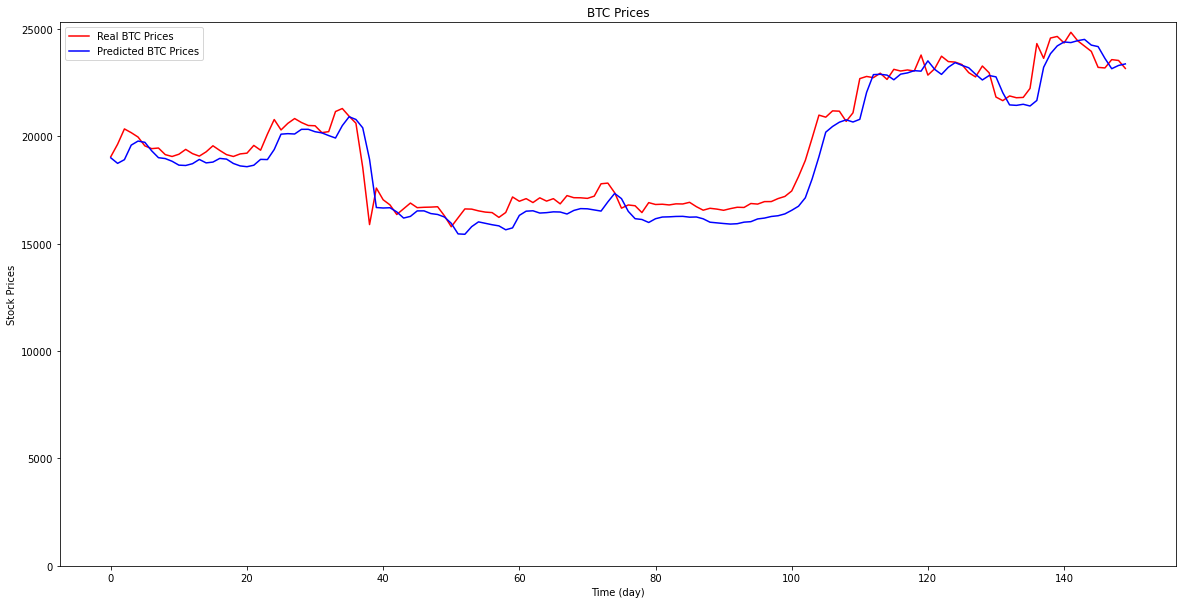

In [11]:
y_test = scala_y.inverse_transform(y_test)
plt.figure(figsize=(20,10))
plt.plot(y_test, color="red", label=f"Real BTC Prices")
plt.plot(predict_price[0:], color="blue", label=f"Predicted BTC Prices")
plt.title(f"BTC Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

TEST

In [12]:
mae = mean_absolute_error(y_test, predict_price)
mape = mean_absolute_percentage_error(y_test, predict_price)
mse = mean_squared_error(y_test, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 582.20
MAPE: 3.08%
MSE: 568029.27
RMSE: 753.68
R2: 0.92


In [13]:
# predict_price_test = model.predict(x_test)
# predict_price_test = scala_y.inverse_transform(predict_price_test)
# y_test = scala_y.inverse_transform(y_test)



In [14]:
# validate = []
# for predict in predict_price_test:
#     predict= elasticnet.predict(np.array([predict]).reshape(-1,1))[0]
#     validate.append(predict)
# df_predict = pd.concat([pd.DataFrame(predict_price_test,columns=['predict_price_test'],index=None), pd.DataFrame(y_test,columns=['y_test'],index=None)], axis=1)
# df_predict['final_predict'] = df_predict['predict_price_test'] + validate
# print(df_predict.to_csv('result.csv'))